# Relhum_ice and its helper function _relhum_ice from meteorology.py
This function just accepts NumPy array, list, and float inputs. So, there is no need to port for xarray and dask array; however, it also works with xarray without dask (tested).

In [1]:
import time
import unittest
from test.test_meteorology import Test_relhum_ice

import cupy as cp
import dask
import numpy as np
import pandas as pd
import xarray as xr
import src.geocat.comp.meteorology as geo
csvpath = "relhum_ice_ported_test_numpy.csv"

## Plotting and Validation

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(allData,name):
    arraysizes = np.unique(allData['ArraySize'])
    sd_numpy = np.zeros(len(arraysizes))
    sd_cupy = np.zeros(len(arraysizes))
    y_numpy = np.zeros(len(arraysizes))
    y_cupy = np.zeros(len(arraysizes))
    plt.rcParams.update({'font.size': 20})
    for i in range(0,len(arraysizes)):
        cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
        numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
        y_cupy[i] = np.mean(cupydata['Runtime(s)'])
        y_numpy[i] = np.mean(numpydata['Runtime(s)'])
        sd_cupy[i] = np.std(cupydata['Runtime(s)'])
        sd_numpy[i] = np.std(numpydata['Runtime(s)'])
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o',label='numpy')
    ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o',label='cupy')
    ax.legend();  # Add a legend.
    ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
    ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
    ax.set_title(("Test_relhum_ice"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(name,dpi=fig.dpi)
    
def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)

## Initializing CPU and CUDA Clusters

In [3]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCPU = PBSCluster(memory='100 GB',
                     processes=36,
                     cores=36,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=36:mem=100gb')
print(clusterCPU.job_script())
clusterCPU.scale(1)
client = Client(clusterCPU)
#cluster.close()
client

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=36:mem=100gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:34944 --nthreads 1 --nprocs 36 --memory-limit 2.59GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:34944,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCUDA = PBSCluster(memory='200 GB',
                     processes=1,
                     cores=1,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=1:ngpus=1:mem=200gb')
print(clusterCUDA.job_script())
clusterCUDA.scale(1)
client = Client(clusterCUDA)
#cluster.close()
client

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=1:ngpus=1:mem=200gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:42414 --nthreads 1 --memory-limit 186.26GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39216 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/39216/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/39216/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:42414,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/39216/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Initializing Arrays

In [5]:
max_power = 8
chunksize = 10**5
p_def_arrays = []
tc_def_arrays = []
w_def_arrays = []
tk_def_arrays = []
for i in range(1,max_power):
    ArraySize = 10**i
    p_def_arrays.append(xr.DataArray(np.random.uniform(low=2000,high=100800,size=10**i)))
    tc_def_arrays.append(xr.DataArray(np.random.uniform(low=-10,high=0,size=10**i)))
    w_def_arrays.append(xr.DataArray(np.random.uniform(low=0,high=0.0037,size=10**i)))
for tc in tc_def_arrays:
    tk_def_arrays.append(xr.DataArray(tc + 273.15))
numpy_results = []
cupy_results = []


## Testing Numpy input and CPU

In [6]:
xp = np
for i in range(max_power-1):
    p_def = p_def_arrays[i].data
    w_def = w_def_arrays[i].data
    tk_def = tk_def_arrays[i].data
    rh_gt_1 = geo.relhum_ice(tk_def, w_def, p_def, use_gpu = False)

In [7]:
type(rh_gt_1)

numpy.ndarray

## Testing Numpy input and GPU

In [8]:
for i in range(max_power-1):
    p_def = p_def_arrays[i].data
    w_def = w_def_arrays[i].data
    tk_def = tk_def_arrays[i].data
    rh_gt_2 = geo.relhum_ice(tk_def, w_def, p_def, use_gpu = True)

In [9]:
rh_gt_2.device

<CUDA Device 0>

## Testing Xarray input and CPU

In [10]:
import xarray as xr
for i in range(max_power-1):
    p_def = p_def_arrays[i]
    w_def = w_def_arrays[i]
    tk_def = tk_def_arrays[i]
    rh_gt_1 = geo.relhum_ice(tk_def, w_def, p_def, use_gpu = False)

In [11]:
type(rh_gt_1.data)

numpy.ndarray

## Testing Xarray input and GPU

In [12]:
for i in range(max_power-1):
    p_def = p_def_arrays[i]
    w_def = w_def_arrays[i]
    tk_def = tk_def_arrays[i]
    rh_gt_2 = geo.relhum_ice(tk_def, w_def, p_def, use_gpu = True)

In [13]:
rh_gt_2.data.device

<CUDA Device 0>

## Unittests with CPU!

In [2]:
test = Test_relhum_ice()

test.test_float_input(use_gpu = False)

## Unittests with GPU

In [3]:
test = Test_relhum_ice()

test.test_float_input(use_gpu = True)

## Benchmark Results for different Array Sizes (NUMPY/CUPY)

Relhum_ice
Array size:  10
numpy 1.8405914306640626e-05 seconds
cupy 0.0004099607467651367 seconds
Array size:  100
numpy 2.064704895019531e-05 seconds
cupy 0.00029113292694091795 seconds
Array size:  1000
numpy 2.536773681640625e-05 seconds
cupy 0.00031421184539794924 seconds
Array size:  10000
numpy 8.640289306640624e-05 seconds
cupy 0.0003402233123779297 seconds
Array size:  100000
numpy 0.0010057449340820312 seconds
cupy 0.0009355783462524414 seconds
Array size:  1000000
numpy 0.01478590965270996 seconds
cupy 0.006012248992919922 seconds
Array size:  10000000
numpy 0.26353437900543214 seconds
cupy 0.05744280815124512 seconds


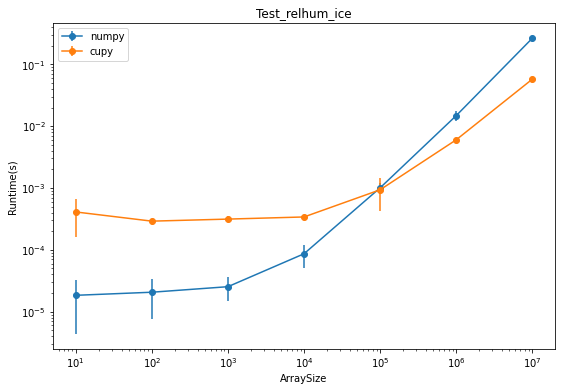

In [21]:
#Test_relhum main body
Routine = "Relhum_ice"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    p_def = p_def_arrays[i-1].data
    tk_def = tk_def_arrays[i-1].data
    w_def = w_def_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repsize = 10
        repeat = np.zeros([repsize])
        for rep in range(0,repsize):
            #create different sizes of arrays
            if(xp == cp):
                res_cupy = geo.relhum_ice(tk_def, w_def, p_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                res_cupy = geo.relhum_ice(tk_def, w_def, p_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                time1 = time.time()
                res_numpy = geo.relhum_ice(tk_def, w_def,p_def,False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Input':"NumPy input",
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}

        allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")
    test_validation(res_numpy,res_cupy)
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_relhum_ice_ported_numpy.jpg")

## Results for different ArraySizes Xarray (with NumPy/CuPy arrays inside the Xarray)

### Test Relhum_ice on CPU

In [22]:
csvpath = "relhum_ice_ported_test_xarray.csv"
#Test_relhum main body
Routine = "Relhum"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    p_def = p_def_arrays[i-1].data
    tk_def = tk_def_arrays[i-1].data
    w_def = w_def_arrays[i-1].data
    #for numpy and cupy both
    xp = np 
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
    #create different sizes of arrays
        numpy_res = geo.relhum_ice(tk_def, w_def, p_def,False)
        time1 = time.time()
        numpy_res = geo.relhum_ice(tk_def, w_def, p_def,False)
        time2 = time.time()
        repeat[rep] = time2-time1
    numpy_results.append(numpy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

Relhum
Array size:  10
numpy 1.3780593872070312e-05 seconds
Array size:  100
numpy 1.4901161193847656e-05 seconds
Array size:  1000
numpy 2.226829528808594e-05 seconds
Array size:  10000
numpy 0.00042285919189453123 seconds
Array size:  100000
numpy 0.0009598255157470704 seconds
Array size:  1000000
numpy 0.013452649116516113 seconds
Array size:  10000000
numpy 0.27206475734710694 seconds


### Test Relhum_ice on GPU

Relhum
Array size:  10
cupy 0.00029878616333007814 seconds
Array size:  100
cupy 0.00028231143951416013 seconds
Array size:  1000
cupy 0.00030086040496826174 seconds
Array size:  10000
cupy 0.00035996437072753905 seconds
Array size:  100000
cupy 0.0007845401763916015 seconds
Array size:  1000000
cupy 0.006602883338928223 seconds
Array size:  10000000
cupy 0.05651581287384033 seconds


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


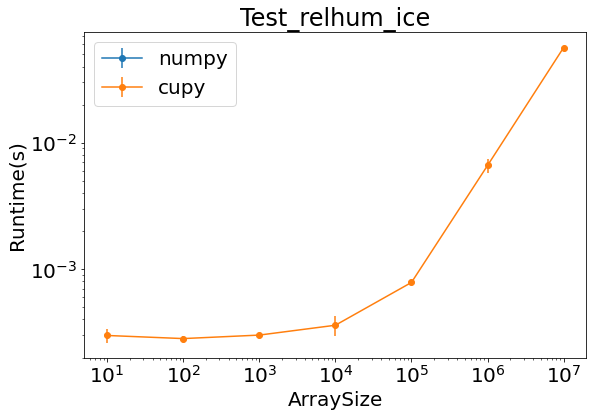

In [23]:
#Test_relhum main body
Routine = "Relhum"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    p_def = p_def_arrays[i-1].data
    tk_def = tk_def_arrays[i-1].data
    w_def = w_def_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    xp = cp
        #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.relhum_ice(tk_def, w_def, p_def,True)
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.relhum_ice(tk_def, w_def, p_def,True)
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
    cupy_results.append(cupy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_relhum_ice_ported_xarray.jpg")

### Validation

In [25]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i],numpy_results[i])

In [26]:
cupy_results[0]

array([ 1.35247119, 90.72837693, 14.46813122, 62.55425514,  0.97437599,
       61.87859257, 67.26575958,  7.27584035, 43.18261208, 26.39522288])

In [27]:
numpy_results[0]

array([ 1.35247119, 90.72837693, 14.46813122, 62.55425514,  0.97437599,
       61.87859257, 67.26575958,  7.27584035, 43.18261208, 26.39522288])